# Dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import yfinance as yf

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from numpy.linalg import inv, eig, svd
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix 
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

from matplotlib.ticker import FuncFormatter

# Definitions and Data

In [2]:
# load dataset
#scraping wikipedia to fetch S&P 500 and DJI stock list
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP_stocks = pd.read_html(snp500url)[0]
SP_tickers = SP_stocks['Symbol'].to_list()

DJI = (
    pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
)
DJI_symbols = DJI.Symbol.tolist()

In [238]:
def download_stocks(tickers,start='2014-01-01',end='2018-01-01'):
    return yf.download(tickers, start = start, end = end)

def remove_null(df, cutoff = .99):
    df = df.dropna(axis=1)
    df = df.dropna(thresh=int(df.shape[1]*cutoff))
    return df

def winsorize(df,q=.025):
    clipped = df.clip(lower=df.quantile(q=q),
                   upper=df.quantile(q=1-q),
                   axis=1)
    return clipped

def df_scaler(df):
    scaler = StandardScaler().fit(df)
    return scaler

def train_test_split(df,percentage = .8):
    
    train_size = int(len(df)*percentage)
    train_set = df[:train_size]
    test_set = df[train_size:]
    
    return train_set, test_set

def normalize_data(df_train,df_test):
    scaler = StandardScaler().fit(df_train)
    
    train = pd.DataFrame(scaler.transform(df_train),
                         columns = df_train.columns,
                         index = df_train.index)
    
    test = pd.DataFrame(scaler.transform(df_test),
                        columns = df_test.columns,
                        index = df_test.index)
    
    return train, test


def get_distance_matrix(corr):
    """Compute distance matrix from correlation;
    0 <= d[i,j] <= 1"""
    return np.sqrt((1 - corr) / 2)

def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        #sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = pd.concat([sort_idx,df0])
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

def clustered_corr_plot(df,include_ticks = True):
    corr = df.corr()
    
    distance_matrix = get_distance_matrix(corr)
    linkage_matrix = linkage(squareform(distance_matrix), 'single')
    sorted_idx = quasi_diagonalize(linkage_matrix)
    
    clustergrid = sns.clustermap(distance_matrix, 
                             method='single', 
                             row_linkage=linkage_matrix, 
                             col_linkage=linkage_matrix, 
                             center=0);
    plt.close()
    
    sorted_idx = clustergrid.dendrogram_row.reordered_ind
    sorted_tickers = corr.index[sorted_idx].tolist()
    fig, ax = plt.subplots(figsize=(18, 8))

    #sns.heatmap(corr, center = 0, ax=axes[0])
    #axes[0].set_title('Correlation Matrix')
    #fig.tight_layout()

    clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
    
    sns.heatmap(clustered_assets, center = 0, ax=ax)
    ax.set_title('Clustered Correlation')
    if not include_ticks:
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout();
    
    return fig

In [239]:
SP_index = download_stocks('^GSPC')['Adj Close']
DJI_index = download_stocks('^DJI')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [240]:
SP_idx_returns = SP_index.pct_change().dropna()
DJI_idx_returns = DJI_index.pct_change().dropna()

In [241]:
SP_data = download_stocks(SP_tickers)['Adj Close']
SP_data.index = pd.to_datetime(SP_data.index)

DJI_data = download_stocks(DJI_symbols)['Adj Close']
DJI_data.index = pd.to_datetime(DJI_data.index)

[*********************100%***********************]  503 of 503 completed

14 Failed downloads:
- OTIS: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- CTVA: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- CEG: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- BF.B: No data found for this date range, symbol may be delisted
- MRNA: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- GEHC: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- VICI: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- FOXA: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- CDAY: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- OGN: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- FOX: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- CARR: Data doesn't exist for startDate = 1388552400, endDate = 1514782800
- DOW:

In [242]:
DJI_data = remove_null(DJI_data)
SP_data = remove_null(SP_data)

In [243]:
print(SP_data.isna().sum().sum())
print(DJI_data.isna().sum().sum())

0
0


# Data Processing

In [244]:
#SP_returns = SP_data.pct_change().dropna()
#dji_returns = dji_data.pct_change().dropna()

#SP_log_returns = np.log(SP_data/SP_data.shift(1))[1:]
#dji_log_returns = np.log(dji_data/dji_data.shift(1))[1:]
#
#SP_log_returns = winsorize(SP_log_returns)
#dji_log_returns = winsorize(dji_log_returns)

SP_returns = SP_data.pct_change().dropna()
DJI_returns = DJI_data.pct_change().dropna()

SP_returns = winsorize(SP_returns)
DJI_returns = winsorize(DJI_returns)

In [245]:
#SP_train, SP_test = train_test_split(SP_log_returns)
#dji_train, dji_test = train_test_split(dji_log_returns)

SP_train, SP_test = train_test_split(SP_returns)
DJI_train, DJI_test = train_test_split(DJI_returns)

In [246]:
SP_train_scaled = (SP_train-SP_train.mean())/SP_train.std()
SP_test_scaled = (SP_test-SP_train.mean())/SP_train.std()

DJI_train_scaled = (DJI_train-DJI_train.mean())/DJI_train.std()
DJI_test_scaled = (DJI_test-DJI_train.mean())/DJI_train.std()

In [247]:
print('Statistics for SP-500 train set')
print(f'Average normalized return: {SP_train_scaled.mean().mean()}')
print(f'Average standard deviation: {SP_train_scaled.std().mean()}')
print('\n')
print('Statistics for SP-500 test set')
print(f'Average normalized return: {SP_test_scaled.mean().mean()}')
print(f'Average standard deviation: {SP_test_scaled.std().mean()}')

Statistics for SP-500 train set
Average normalized return: -7.594809248057664e-19
Average standard deviation: 1.0


Statistics for SP-500 test set
Average normalized return: 0.014682797041067045
Average standard deviation: 0.8280152942449787


In [248]:
print('Statistics for DJI train set')
print(f'Average normalized return: {DJI_train_scaled.mean().mean()}')
print(f'Average standard deviation: {DJI_train_scaled.std().mean()}')
print('\n')
print('Statistics for DJI test set')
print(f'Average normalized return: {DJI_test_scaled.mean().mean()}')
print(f'Average standard deviation: {DJI_test_scaled.std().mean()}')

Statistics for DJI train set
Average normalized return: 3.8093087137593345e-19
Average standard deviation: 0.9999999999999999


Statistics for DJI test set
Average normalized return: 0.028684321630498014
Average standard deviation: 0.7780339550122434


# EDA

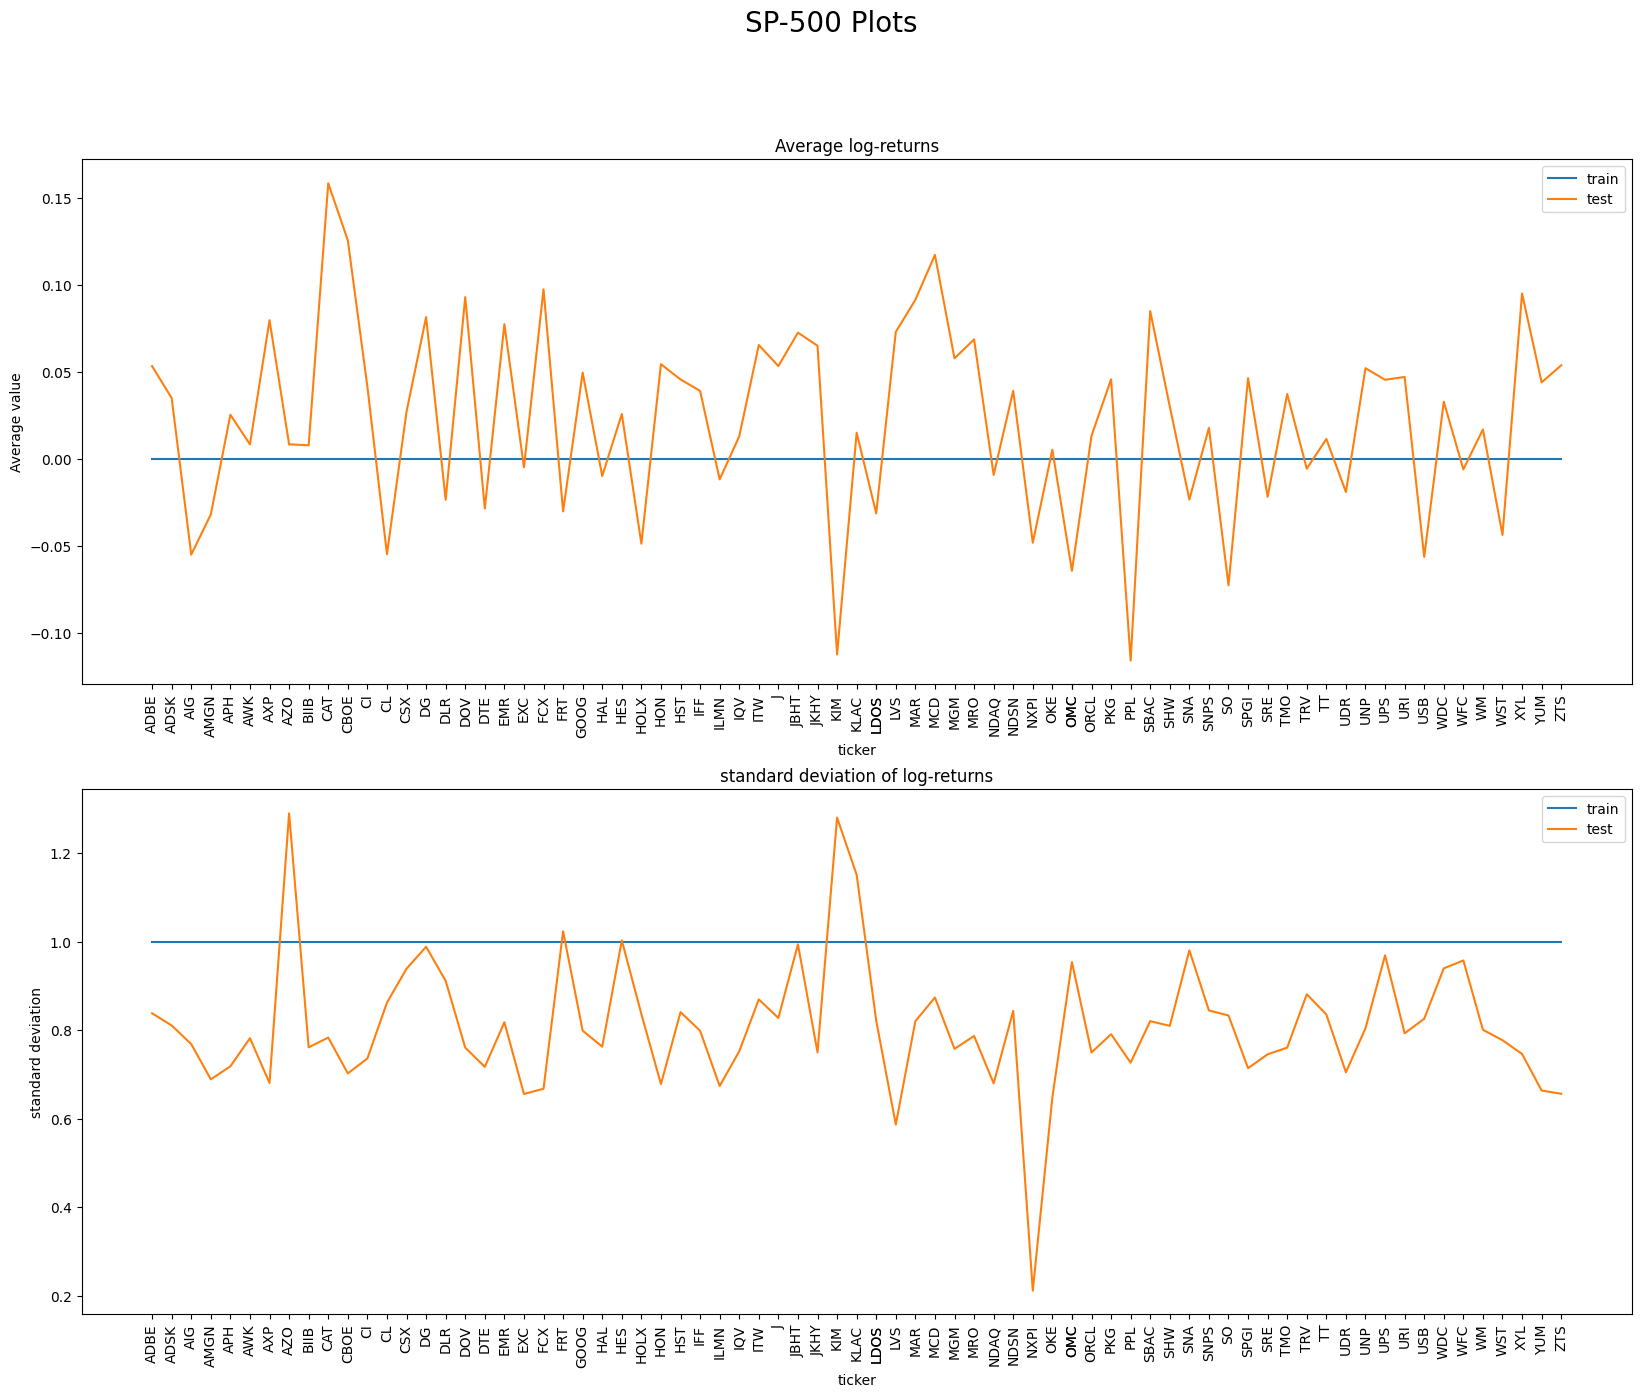

In [249]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

np.random.seed(110)

random_stocks = sorted(np.random.choice(SP_train_scaled.shape[1],75))
random_tickers = list(SP_train_scaled.columns[random_stocks])

SP_train_scaled_sample = SP_train_scaled[random_tickers]
SP_test_scaled_sample = SP_test_scaled[random_tickers]

axes[0].plot(SP_train_scaled_sample.mean(),label='train')
axes[0].plot(SP_test_scaled_sample.mean(),label='test')
axes[0].set_title('Average log-returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
axes[0].set_xticks(random_tickers)
axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(SP_train_scaled_sample.std(),label='train')
axes[1].plot(SP_test_scaled_sample.std(),label='test')
axes[1].set_title('standard deviation of log-returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')
axes[1].set_xticks(random_tickers)
axes[1].set_xticklabels(random_tickers,rotation=90);

plt.suptitle('SP-500 Plots',fontsize=20)

plt.show();

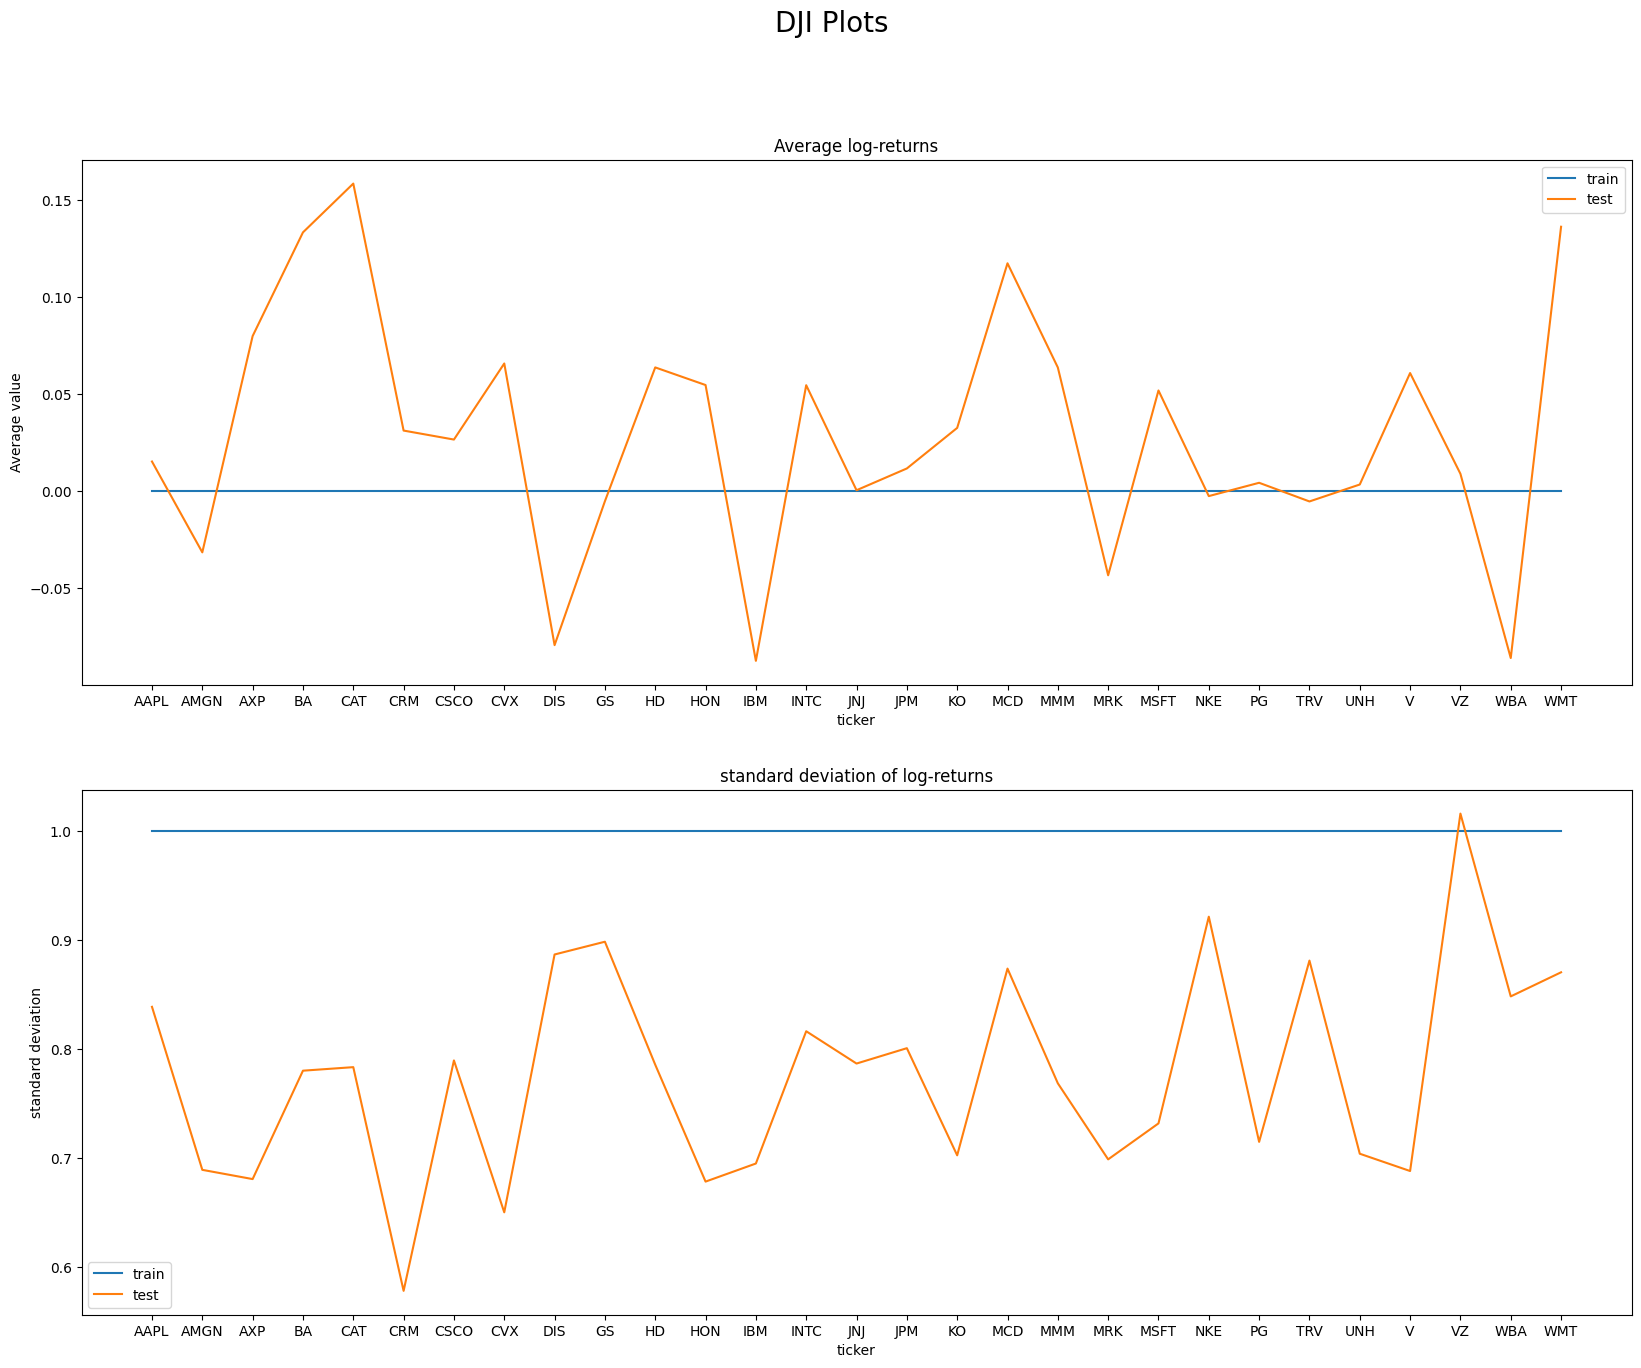

In [250]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

axes[0].plot(DJI_train_scaled.mean(),label='train')
axes[0].plot(DJI_test_scaled.mean(),label='test')
axes[0].set_title('Average log-returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
#axes[0].set_xticks(random_tickers)
#axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(DJI_train_scaled.std(),label='train')
axes[1].plot(DJI_test_scaled.std(),label='test')
axes[1].set_title('standard deviation of log-returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')


plt.suptitle('DJI Plots',fontsize=20)

plt.show();

In [251]:
SP_train_cov = SP_train.cov()
SP_test_cov = SP_test.cov()

SP_train_corr = SP_train.corr()
SP_test_corr = SP_test.corr()

DJI_train_cov = DJI_train.cov()
DJI_test_cov = DJI_test.cov()

DJI_train_corr = DJI_train.corr()
DJI_test_corr = DJI_test.corr()

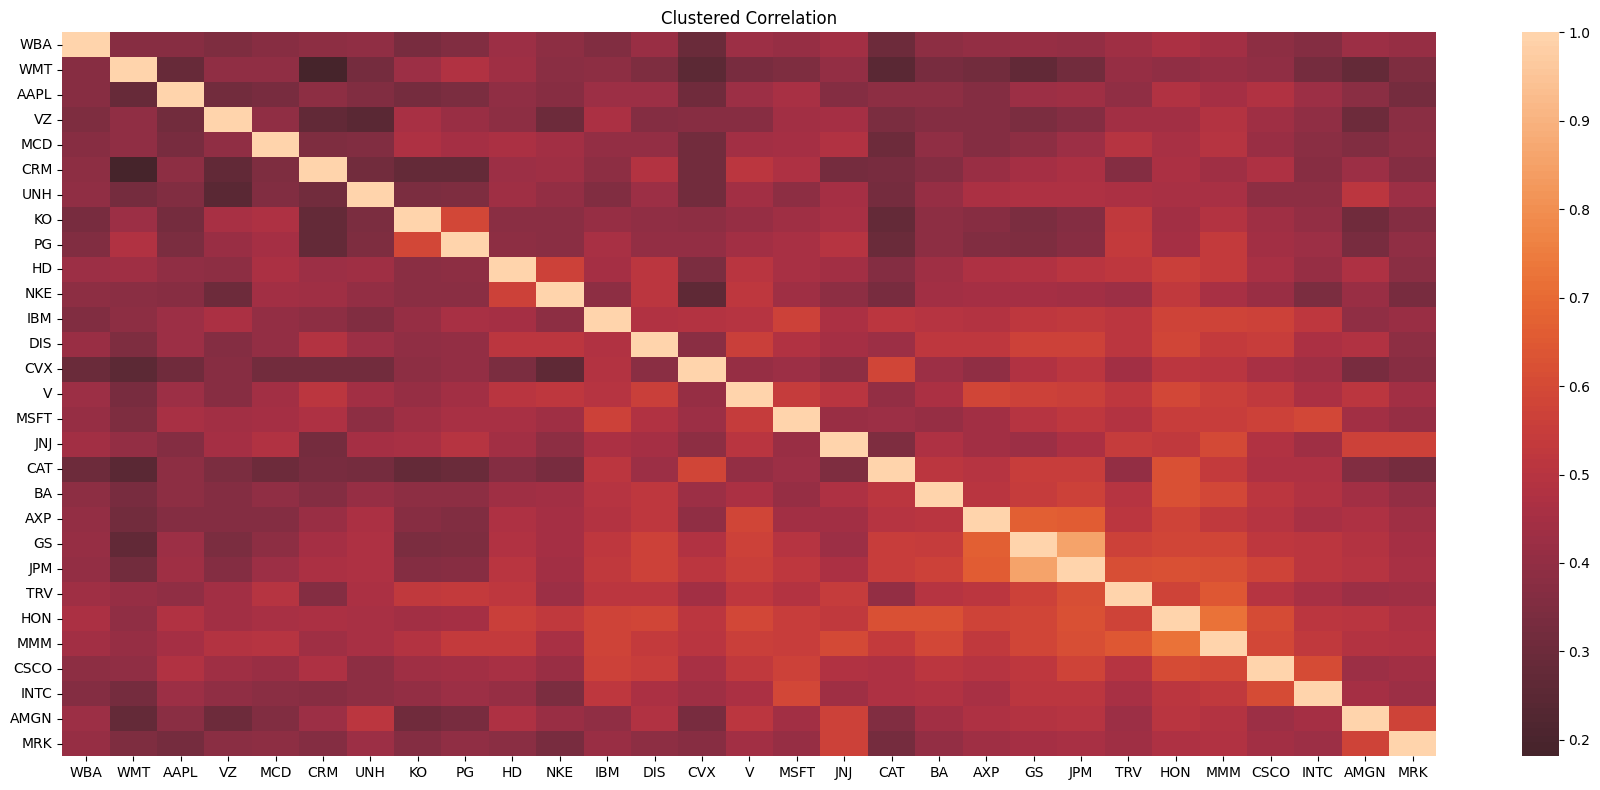

In [252]:
clustered_corr_plot(DJI_train);

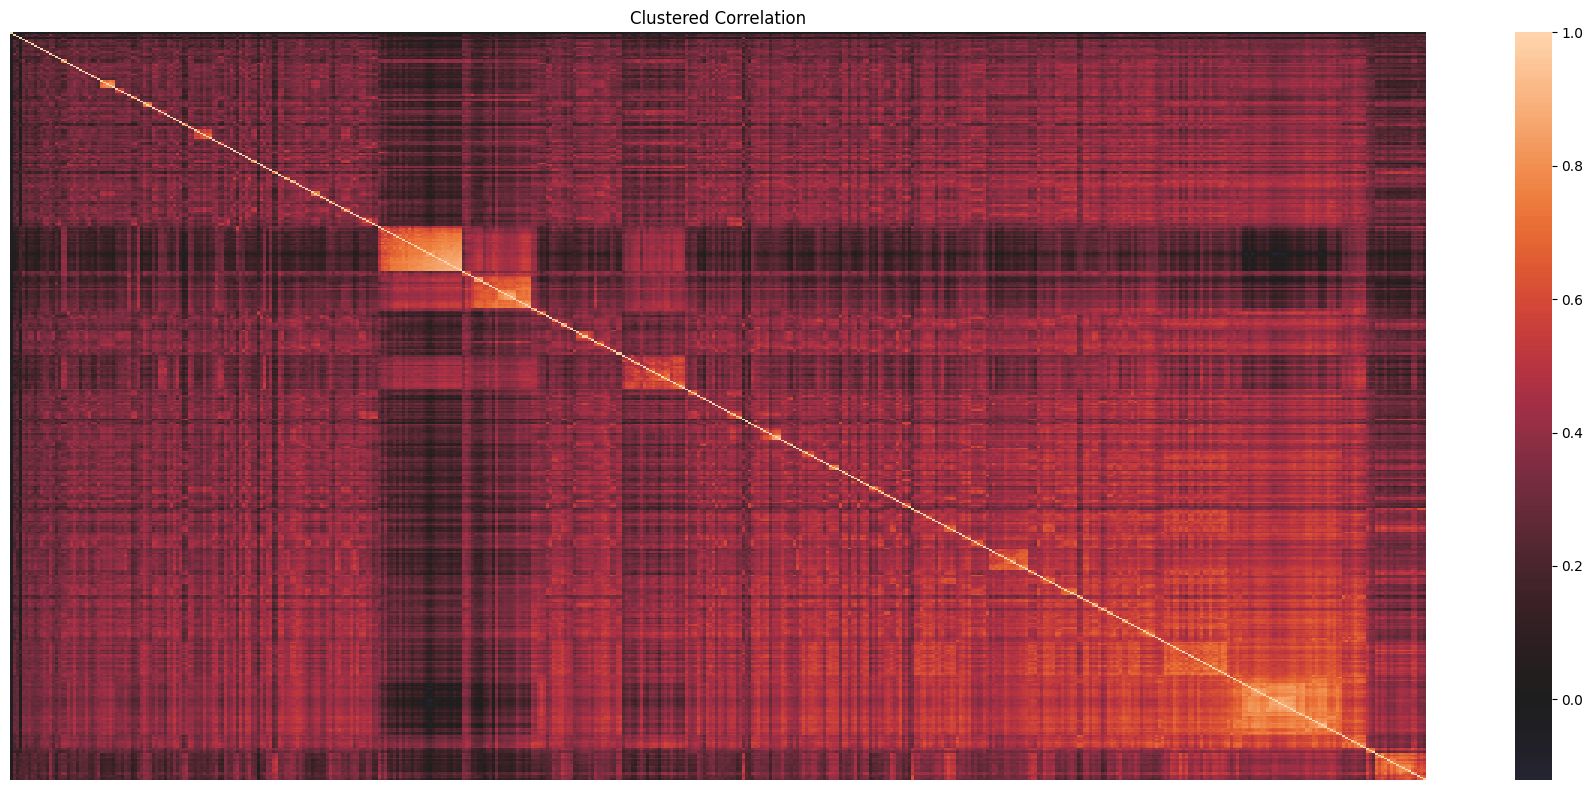

In [253]:
clustered_corr_plot(SP_train,include_ticks=False);

In [254]:
PCA_SP = PCA().fit(SP_train_scaled)
PCA_DJI = PCA().fit(DJI_train_scaled)

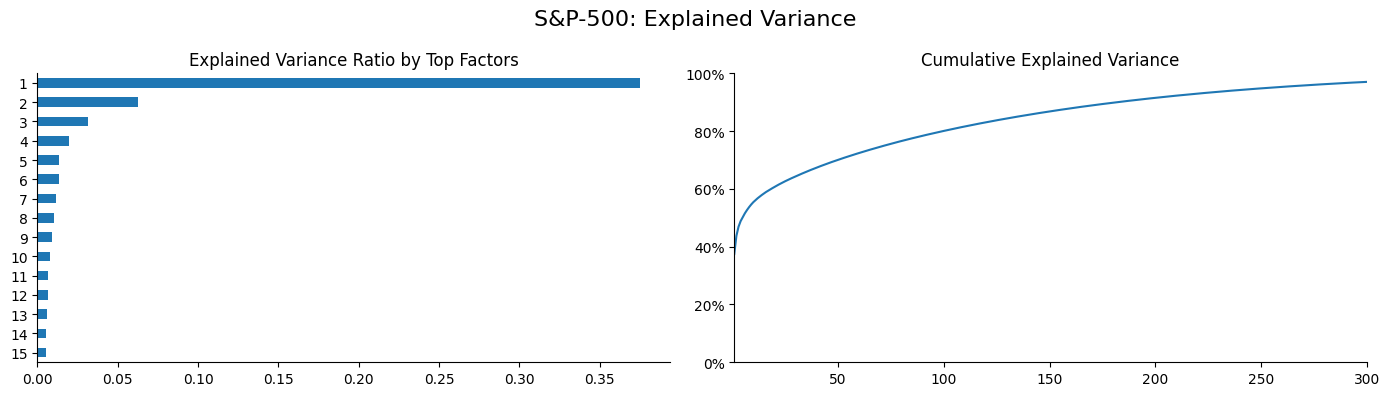

In [255]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(PCA_SP.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.suptitle("S&P-500: Explained Variance", size=16)
fig.tight_layout()

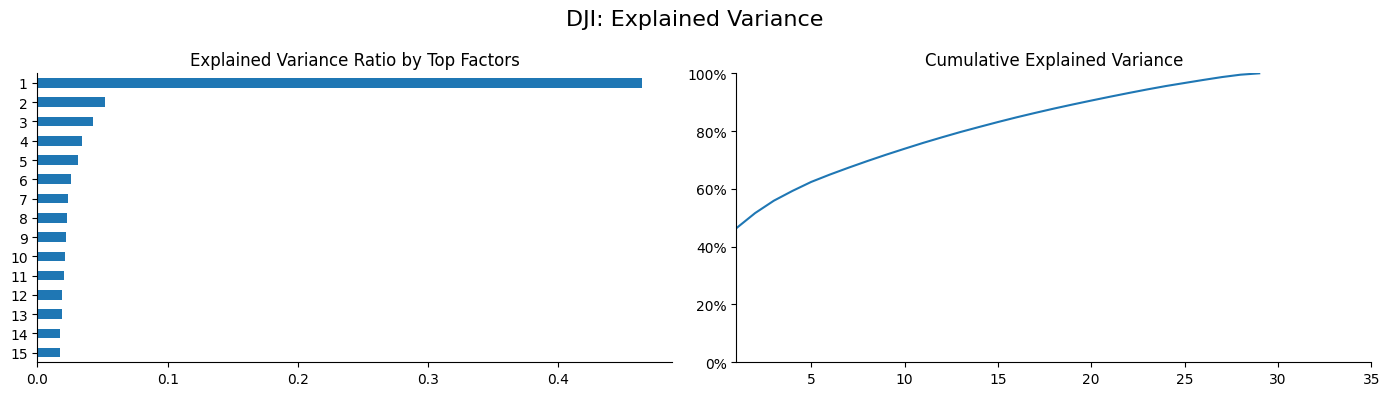

In [256]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(PCA_DJI.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 35))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.suptitle("DJI: Explained Variance", size=16)
fig.tight_layout()

In [257]:
DJI_eigvals, DJI_eigvecs = np.linalg.eigh(DJI_train_corr)

DJI_eigvals = DJI_eigvals[::-1]
DJI_eigvecs = DJI_eigvecs[:,::-1]

print(np.allclose(PCA_DJI.explained_variance_ratio_,(DJI_eigvals/np.sum(DJI_eigvals))))

print(np.allclose(np.abs(np.dot(PCA_DJI.components_,DJI_eigvecs)),
            np.eye(DJI_eigvecs.shape[0])))

True
True


In [258]:
SP_eigvals, SP_eigvecs = np.linalg.eigh(SP_train_corr)

SP_eigvals = SP_eigvals[::-1]
SP_eigvecs = SP_eigvecs[:,::-1]

print(np.allclose(PCA_SP.explained_variance_ratio_,(SP_eigvals/np.sum(SP_eigvals))))

print(np.allclose(np.abs(np.dot(PCA_SP.components_,SP_eigvecs)),
            np.eye(SP_eigvecs.shape[0])))

True
True


In [259]:
DJI_evecs_std = (DJI_eigvecs.T/(DJI_train.std().values)).T

np.allclose((DJI_train.dot(DJI_evecs_std)).corr().values,
            np.eye(DJI_evecs_std.shape[0]))

True

In [260]:
SP_evecs_std = (SP_eigvecs.T/(SP_train.std().values)).T

np.allclose((SP_train.dot(SP_evecs_std)).corr().values,
            np.eye(SP_evecs_std.shape[0]))

True

In [261]:
for i in range(DJI_evecs_std.shape[1]):
    DJI_evecs_std[:,i]=DJI_evecs_std[:,i]/np.linalg.norm(DJI_evecs_std[:,i])
    #DJI_evecs_std[:,i] = DJI_evecs_std[:,i]/np.sum(DJI_evecs_std[:,i])
    
for i in range(SP_evecs_std.shape[1]):
    SP_evecs_std[:,i]=SP_evecs_std[:,i]/np.linalg.norm(SP_evecs_std[:,i])
    #SP_evecs_std[:,i] = SP_evecs_std[:,i]/np.sum(SP_evecs_std[:,i])

In [262]:
DJI_eport_train = DJI_train.dot(DJI_evecs_std)
DJI_eport_test = DJI_test.dot(DJI_evecs_std)

SP_eport_train = SP_train.dot(SP_evecs_std)
SP_eport_test = SP_test.dot(SP_evecs_std)

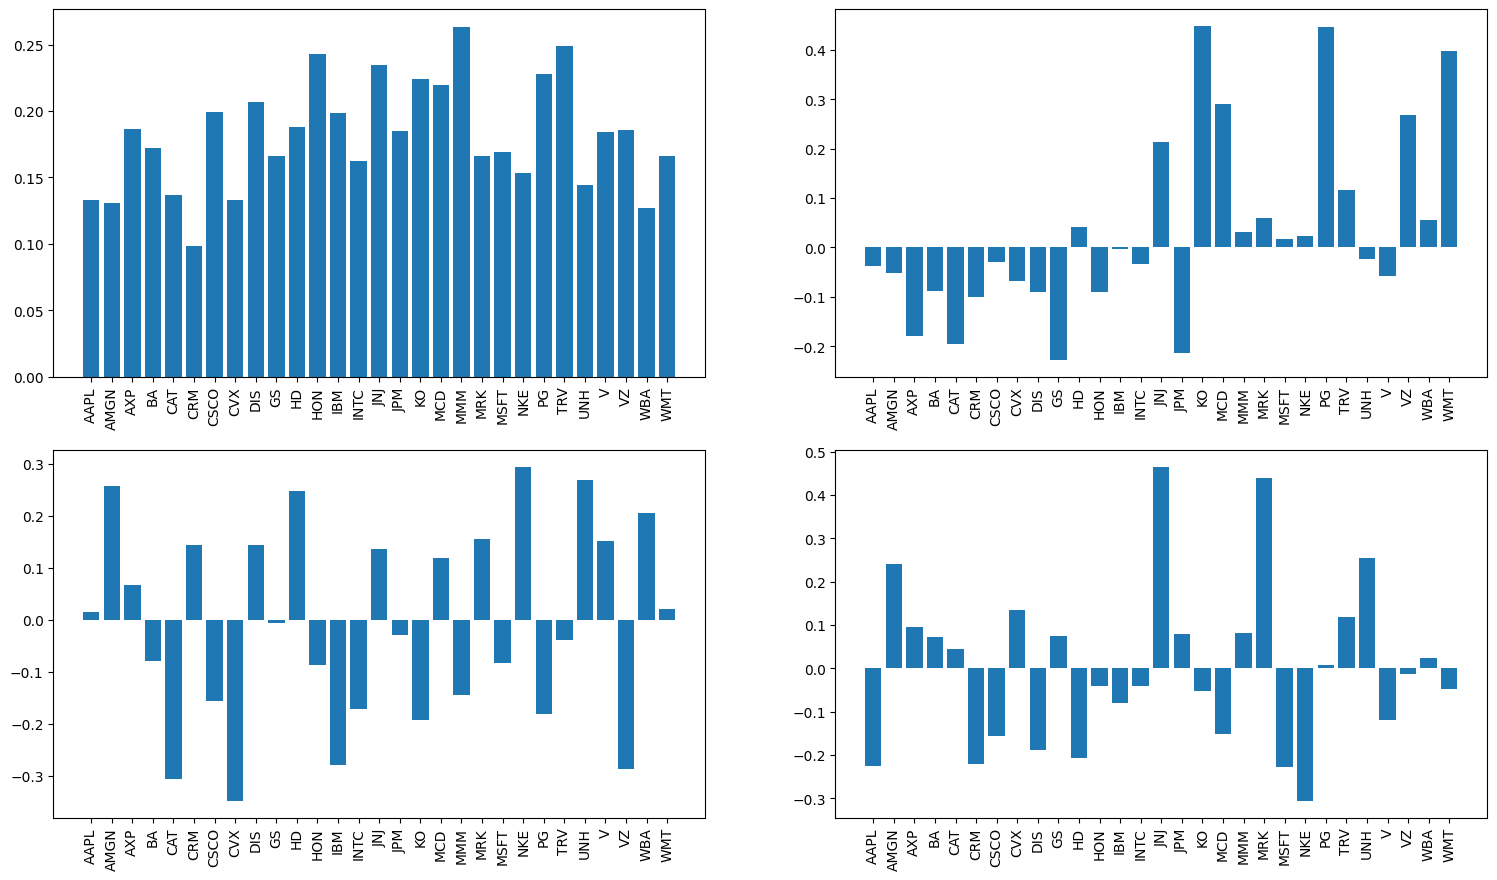

In [263]:
fig, axes = plt.subplots(2,2,sharex=False)

axes[0,0].bar(np.arange(29),
              (DJI_evecs_std[:,0]/np.linalg.norm(DJI_evecs_std[:,0])),
             tick_label=DJI_train.columns);
axes[0,1].bar(np.arange(29),(DJI_evecs_std[:,1]/np.linalg.norm(DJI_evecs_std[:,1])),
             tick_label=DJI_train.columns);
axes[1,0].bar(np.arange(29),(DJI_evecs_std[:,2]/np.linalg.norm(DJI_evecs_std[:,2])),
             tick_label=DJI_train.columns);
axes[1,1].bar(np.arange(29),(DJI_evecs_std[:,3]/np.linalg.norm(DJI_evecs_std[:,3])),
             tick_label=DJI_train.columns);

#axes[0,0].set_xticks(np.arange(29),labels=list(DJI_train.columns),rotation=45);

for i in range(2):
    for j in range(2):
        axes[i,j].set_xticklabels(DJI_train.columns,rotation=90)

fig.set_size_inches(18.5, 10.5)
#axes[0,0].set_xlabel('ticker')
#axes[0,0].set_xticks(np.arange(29));
#axes[0,0].set_xticklabels(DJI_train.columns,rotation=90);

# Sharpe Ratio and Beta

In [264]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a single eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year

    annualized_return_pos = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_return_neg = np.power(np.prod(1-ts_returns),(1/n_years))-1
    
    if annualized_return_pos>annualized_return_neg:
        sign = 1
        annualized_return = annualized_return_pos
    else:
        sign = -1
        annualized_return = annualized_return_neg
    
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe, sign

In [265]:
SP_train_sharpe = np.zeros((SP_eport_train.shape[1],4))

for i, col in enumerate(SP_eport_train.columns):
    SP_train_sharpe[i] = sharpe_ratio(SP_eport_train[col])

df_SP_summary = pd.DataFrame(SP_train_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(SP_train_sharpe.shape[0]))

top_SP_ports = df_SP_summary.sort_values(by='sharpe',ascending=False)[:5]

top_SP_ports_idx = top_SP_ports.index

top_SP_ports

,return,vol,sharpe,sign
466,0.069385,0.022725,3.053267,1.0
467,0.060516,0.023429,2.582924,-1.0
442,0.073991,0.033525,2.207024,-1.0
12,0.754621,0.344363,2.191354,1.0
464,0.053846,0.024596,2.189238,1.0


In [266]:
SP_test_sharpe = np.zeros((SP_eport_test.shape[1],4))

for i, col in enumerate(SP_eport_test.columns):
    SP_test_sharpe[i] = sharpe_ratio(SP_eport_test[col])

df_SP_test_summary = pd.DataFrame(SP_test_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(SP_test_sharpe.shape[0]))

df_SP_test_summary.sort_values(by='sharpe',ascending=False)[:5]

,return,vol,sharpe,sign
0,24.029664,1.388495,17.306267,-1.0
233,0.545504,0.121103,4.504476,-1.0
50,0.743165,0.182792,4.065639,1.0
414,0.374311,0.092751,4.035644,1.0
308,0.442169,0.110119,4.015358,-1.0


In [267]:
DJI_train_sharpe = np.zeros((DJI_eport_train.shape[1],4))

for i, col in enumerate(DJI_eport_train.columns):
    DJI_train_sharpe[i] = sharpe_ratio(DJI_eport_train[col])

df_DJI_summary = pd.DataFrame(DJI_train_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(DJI_train_sharpe.shape[0]))

top_DJI_ports = df_DJI_summary.sort_values(by='sharpe',ascending=False)[:5]

top_DJI_ports

,return,vol,sharpe,sign
0,0.703202,0.601101,1.169857,1.0
12,0.108363,0.120951,0.895927,-1.0
6,0.113721,0.141851,0.801693,1.0
26,0.070677,0.092484,0.764206,-1.0
14,0.085998,0.120167,0.715652,1.0


In [268]:
DJI_test_sharpe = np.zeros((DJI_eport_test.shape[1],4))

for i, col in enumerate(DJI_eport_test.columns):
    DJI_test_sharpe[i] = sharpe_ratio(DJI_eport_test[col])

df_DJI_test_summary = pd.DataFrame(DJI_test_sharpe,columns=['return','vol','sharpe','sign'],
             index=np.arange(DJI_test_sharpe.shape[0]))

df_DJI_test_summary.sort_values(by='sharpe',ascending=False)[:5]

,return,vol,sharpe,sign
0,1.879008,0.309159,6.077808,1.0
17,0.520619,0.134824,3.861466,-1.0
19,0.284088,0.109473,2.595045,-1.0
24,0.207819,0.091247,2.277545,-1.0
10,0.261790,0.115964,2.257508,1.0


In [269]:
df_DJI_test_summary.loc[28,'sign']

-1.0

In [270]:
df_DJI_test_summary.loc[top_DJI_ports.index]

,return,vol,sharpe,sign
0,1.879008,0.309159,6.077808,1.0
12,0.028655,0.117755,0.243340,-1.0
6,0.081112,0.128610,0.630682,1.0
26,0.109242,0.090153,1.211742,-1.0
14,0.013783,0.128716,0.107083,-1.0


In [271]:
Beta = {}

for i in SP_eport_train.columns:
    
    Beta['SP','train',i] = (np.cov(SP_eport_train[i].values,
                                  SP_idx_returns.loc[SP_eport_train.index].values)[0,1]
                            /np.var(SP_idx_returns.loc[SP_eport_train.index]))
    
    Beta['SP','train',i] *= df_SP_summary.loc[i,'sign']
    
    Beta['SP','test',i] = (np.cov(SP_eport_test[i],
                                 SP_idx_returns.loc[SP_eport_test.index])[0,1]
                           /np.var(SP_idx_returns.loc[SP_eport_test.index]))
    
    Beta['SP','test',i] *= df_SP_test_summary.loc[i,'sign']
    
for i in DJI_eport_train.columns:
    
    Beta['DJI','train',i] = (np.cov(DJI_eport_train[i],
                                   DJI_idx_returns.loc[DJI_eport_train.index])[0,1]
                             /np.var(DJI_idx_returns.loc[DJI_eport_train.index]))
    
    Beta['DJI','train',i] *= df_DJI_summary.loc[i,'sign']
    
    Beta['DJI','test',i] = (np.cov(DJI_eport_test[i],
                                  DJI_idx_returns.loc[DJI_eport_test.index])[0,1]
                            /np.var(DJI_idx_returns.loc[DJI_eport_test.index]))
    
    Beta['DJI','test',i] *= df_DJI_test_summary.loc[i,'sign']

In [272]:
print('Beta for SP-500 Eigenportfolios:\n')
for i in range(5):
    print(f"Portfolio {i}: train = {round(Beta['SP','train',i],3)}, test = {round(Beta['SP','test',i],3)}")
    
print('\nBeta for DJI Eigenportfolios:\n')
for i in range(5):
    print(f"Portfolio {i}: train = {round(Beta['DJI','train',i],3)}, test = {round(Beta['DJI','test',i],3)}")

Beta for SP-500 Eigenportfolios:

Portfolio 0: train = 18.578, test = 19.547
Portfolio 1: train = -0.019, test = 2.362
Portfolio 2: train = -0.088, test = 1.124
Portfolio 3: train = -0.06, test = 0.199
Portfolio 4: train = 0.206, test = 0.113

Beta for DJI Eigenportfolios:

Portfolio 0: train = 4.599, test = 4.42
Portfolio 1: train = -0.081, test = -0.638
Portfolio 2: train = -0.072, test = 0.296
Portfolio 3: train = -0.04, test = -0.119
Portfolio 4: train = -0.086, test = 0.141


# Dimensionality Reduction

In [273]:
PCA_SP_dr = PCA(n_components = 'mle').fit(SP_train_scaled)
PCA_DJI_dr = PCA(n_components = 'mle').fit(DJI_train_scaled)

In [274]:
SP_train_reconst = PCA_SP_dr.inverse_transform(
    PCA_SP_dr.transform(SP_train_scaled))
SP_test_reconst = PCA_SP_dr.inverse_transform(
    PCA_SP_dr.transform(SP_test_scaled))


DJI_train_reconst = PCA_DJI_dr.inverse_transform(
    PCA_DJI_dr.transform(DJI_train_scaled))
DJI_test_reconst = PCA_DJI_dr.inverse_transform(
    PCA_DJI_dr.transform(DJI_test_scaled))

In [275]:
print(np.sqrt(np.linalg.norm(SP_train_reconst-SP_train_scaled.values,
               ord='fro')/np.linalg.norm(SP_train_scaled.values,
               ord='fro')))

print(np.sqrt(np.linalg.norm(SP_test_reconst-SP_test_scaled.values,
               ord='fro')/np.linalg.norm(SP_test_scaled.values,
               ord='fro')))

0.6985002280399261
0.8222536792869362


In [276]:
print(np.sqrt(np.linalg.norm(DJI_train_reconst-DJI_train_scaled.values,
               ord='fro')/np.linalg.norm(DJI_train_scaled.values,
               ord='fro')))

print(np.sqrt(np.linalg.norm(DJI_test_reconst-DJI_test_scaled.values,
               ord='fro')/np.linalg.norm(DJI_test_scaled.values,
               ord='fro')))

0.2615700621123662
0.31305714221904685


# Time-Series Predictions

In [289]:
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
from numpy.linalg import LinAlgError

In [278]:
def plot_correlogram(x, lags=None, title=None,vol=False):
    lags = min(10, int(len(x)/5)) if lags is None else lags

    with sns.axes_style('whitegrid'):
        
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)

        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])

        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'

        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'

        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0],auto_ylims=True)
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1],auto_ylims=True)

        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')

        fig.suptitle(title, fontsize=20)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

In [279]:
for i in range(5):
    print(f'portfolio {i}: adfuller p-value = {adfuller(DJI_eport_train[i])[1]}')

portfolio 0: adfuller p-value = 0.0
portfolio 1: adfuller p-value = 0.0
portfolio 2: adfuller p-value = 1.316137628105338e-11
portfolio 3: adfuller p-value = 0.0
portfolio 4: adfuller p-value = 0.0


In [280]:
import warnings
warnings.filterwarnings('ignore')

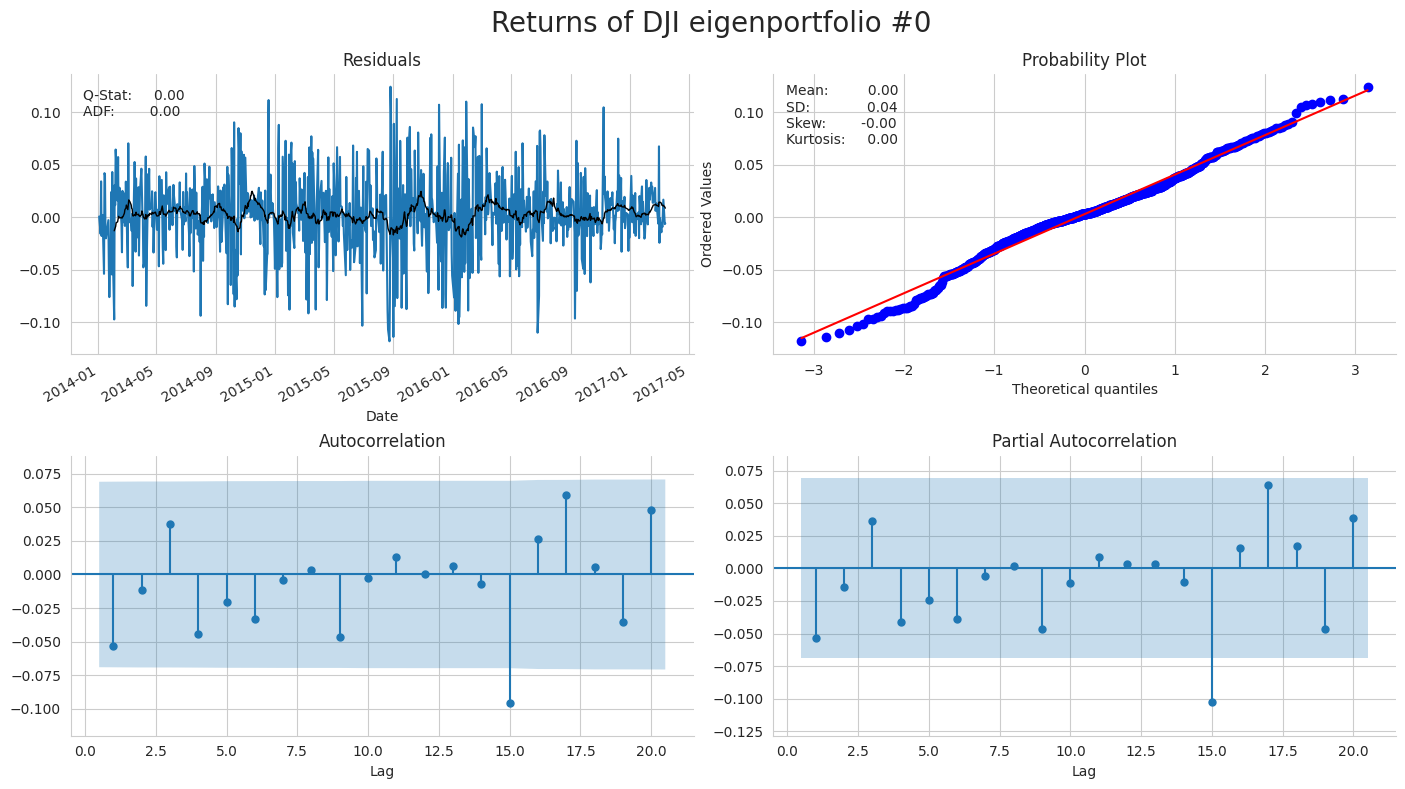

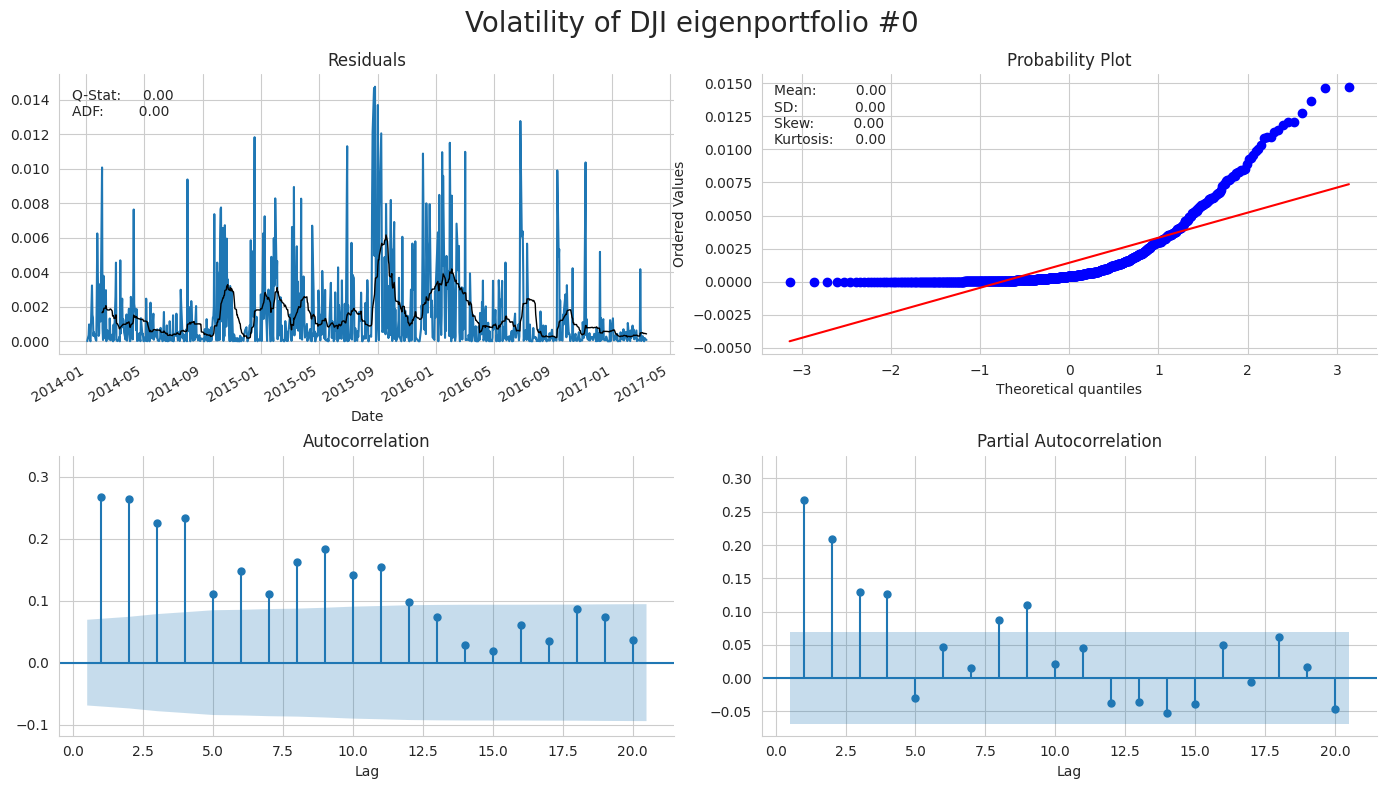

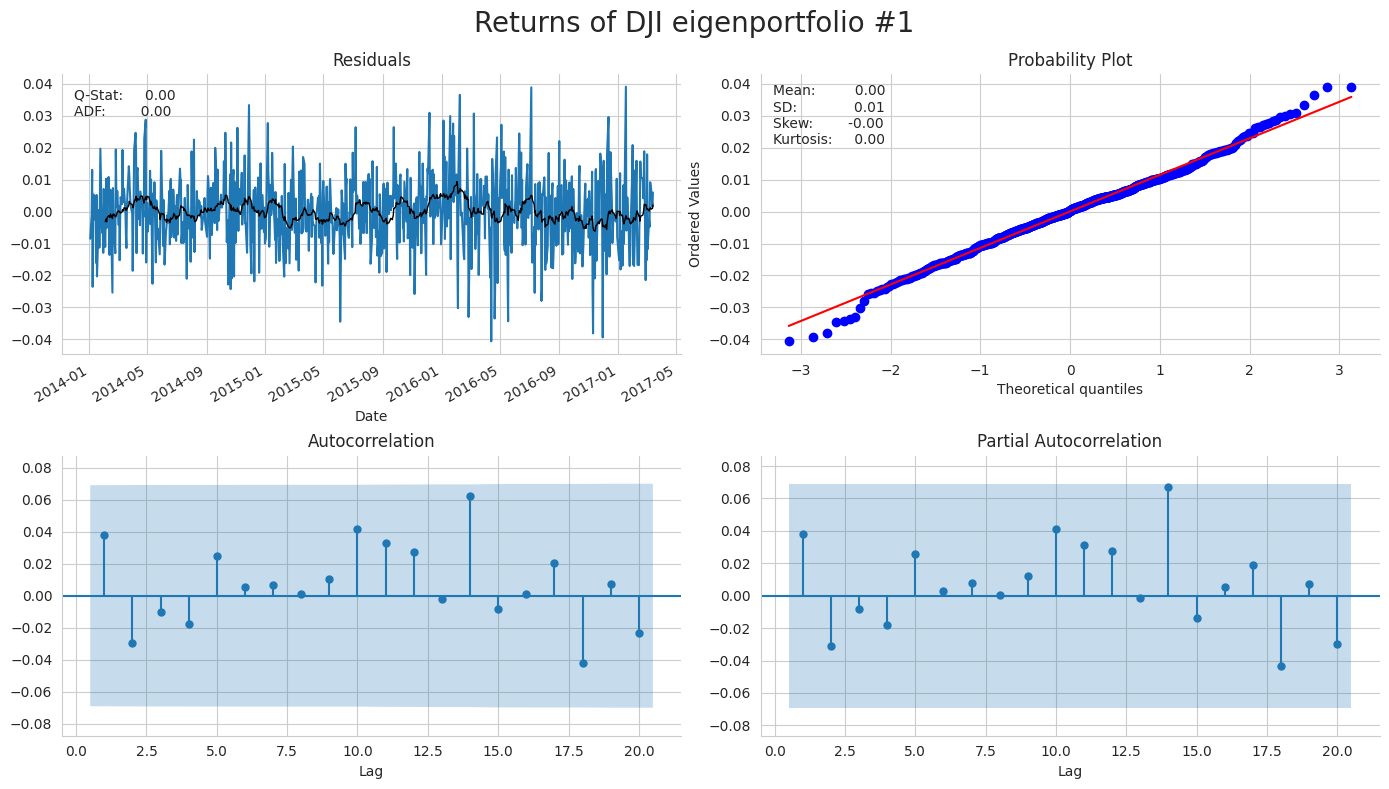

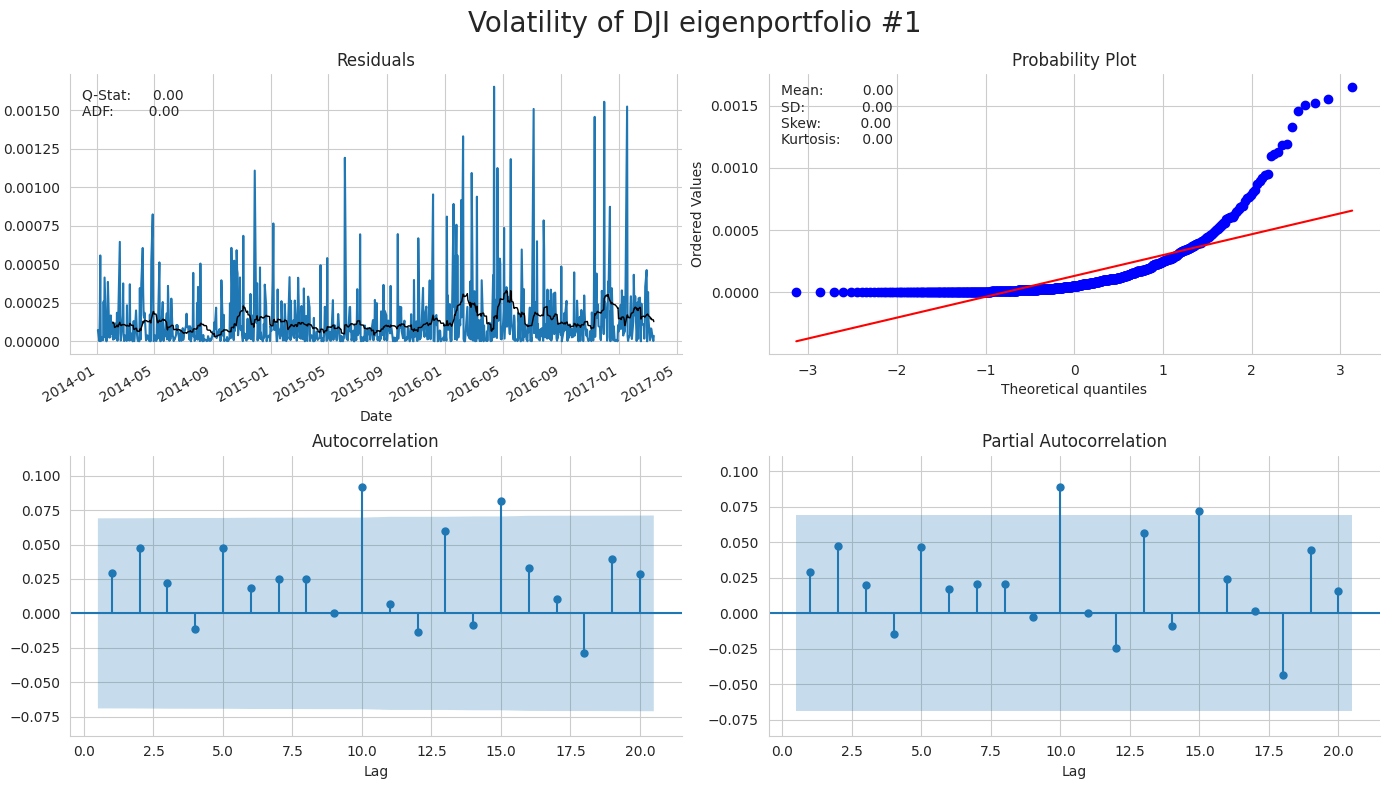

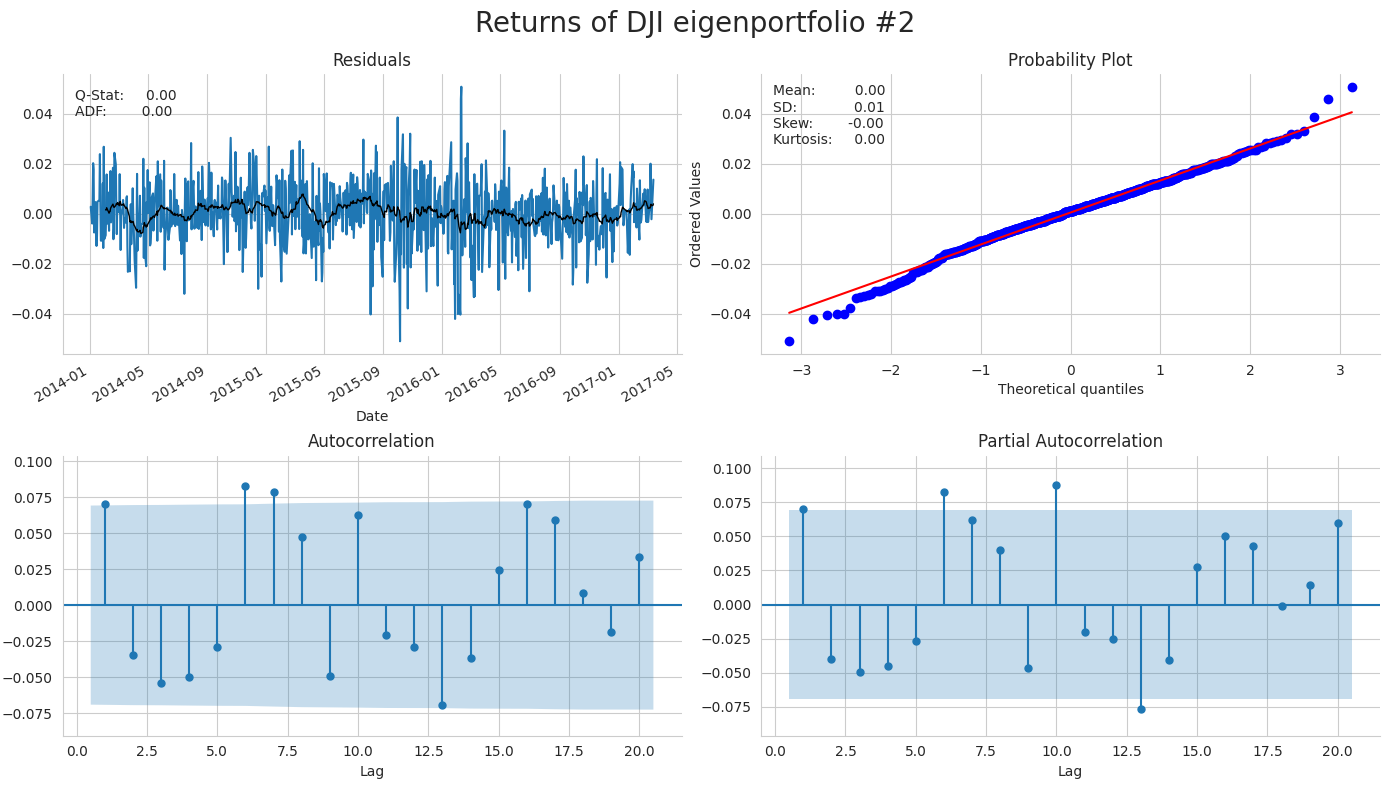

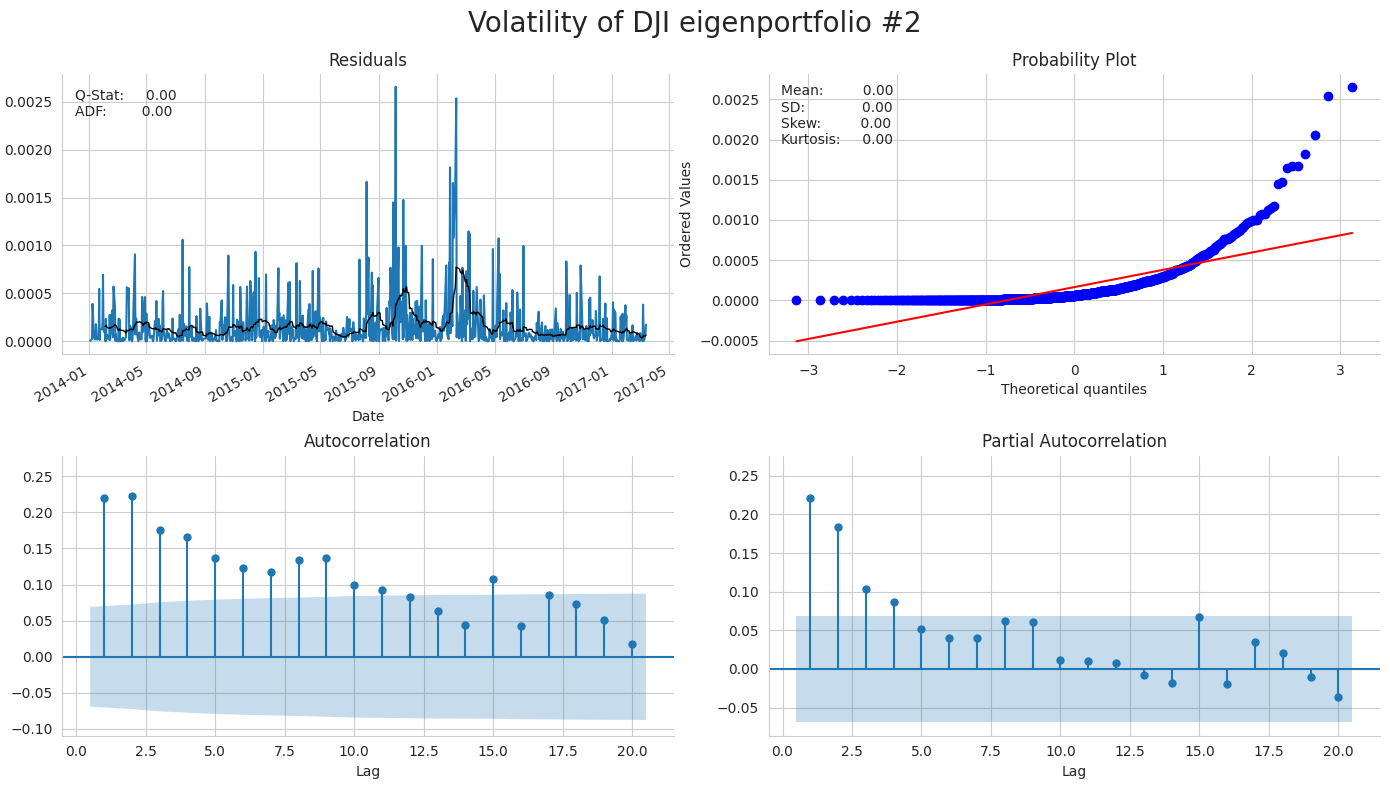

In [281]:
for i in range(3):
    plot_correlogram(DJI_eport_train[i],lags=20,title=f'Returns of DJI eigenportfolio #{i}')
    plot_correlogram((DJI_eport_train[i]-DJI_eport_train[i].mean())**2,
                     lags=20,title=f'Volatility of DJI eigenportfolio #{i}')

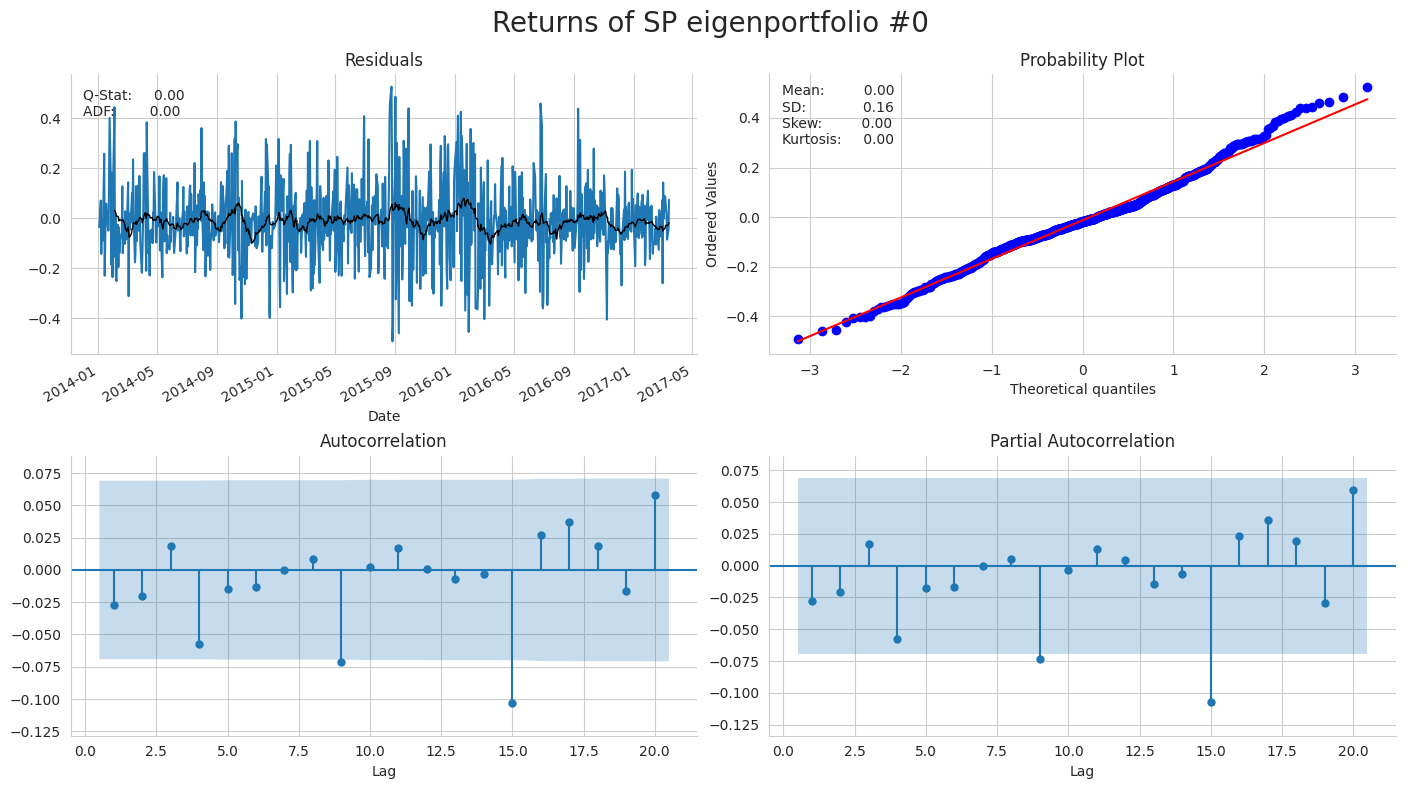

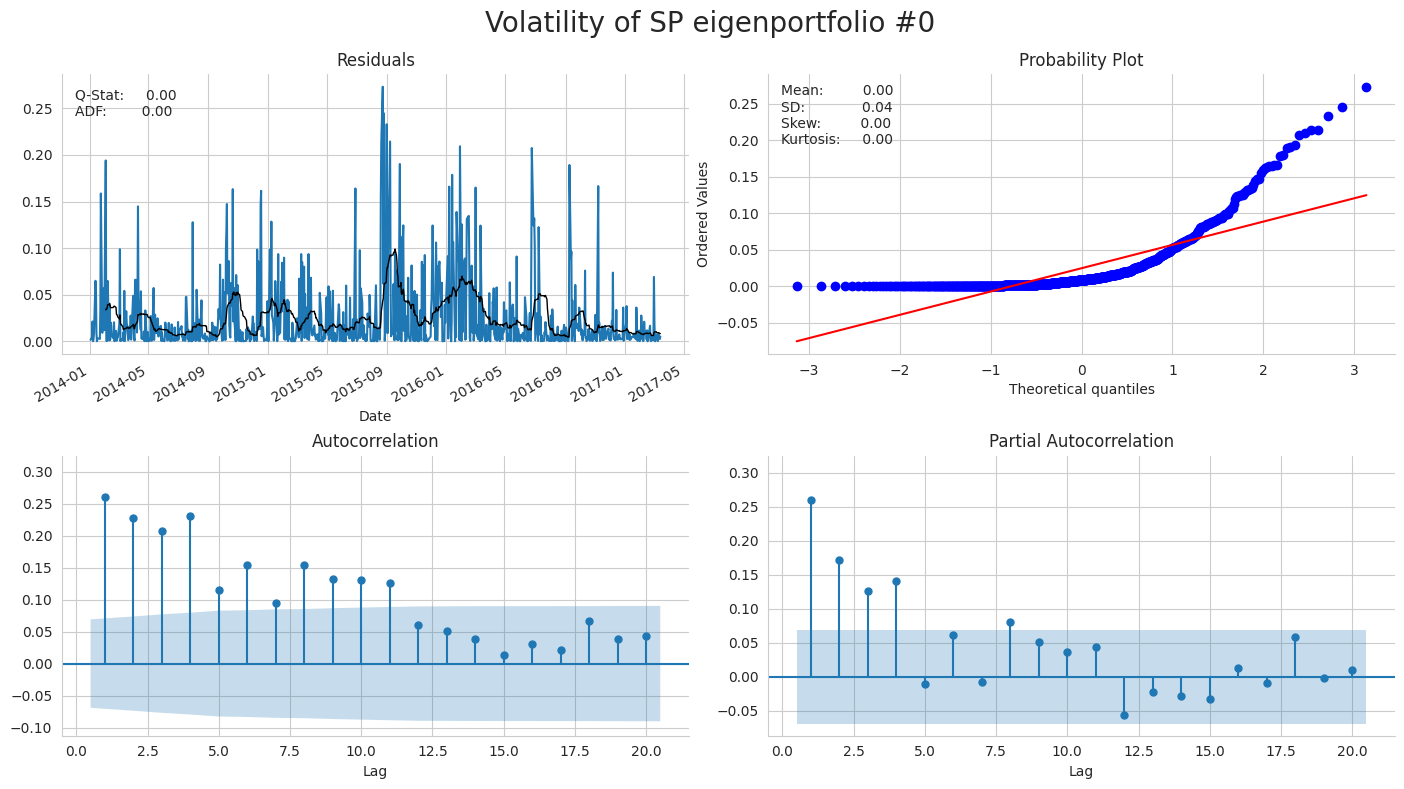

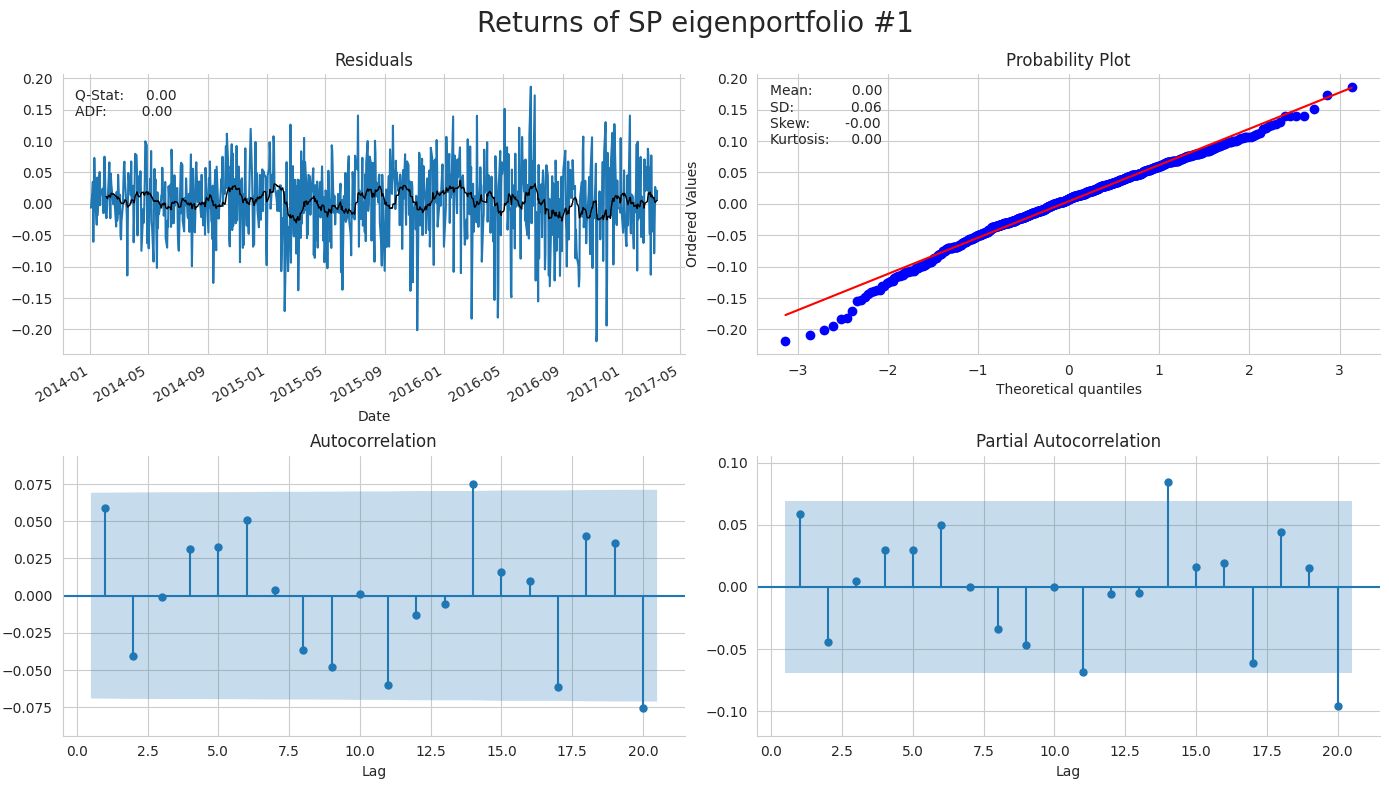

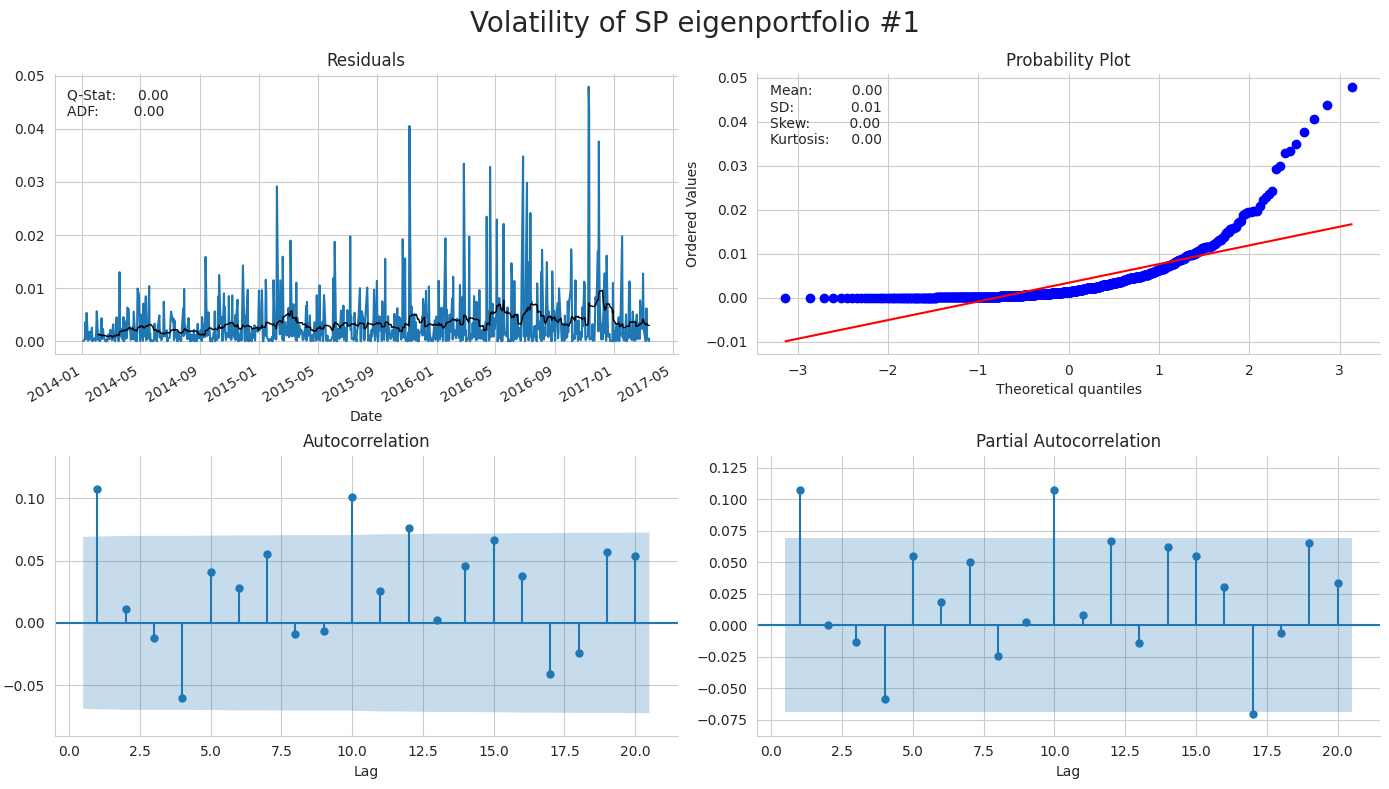

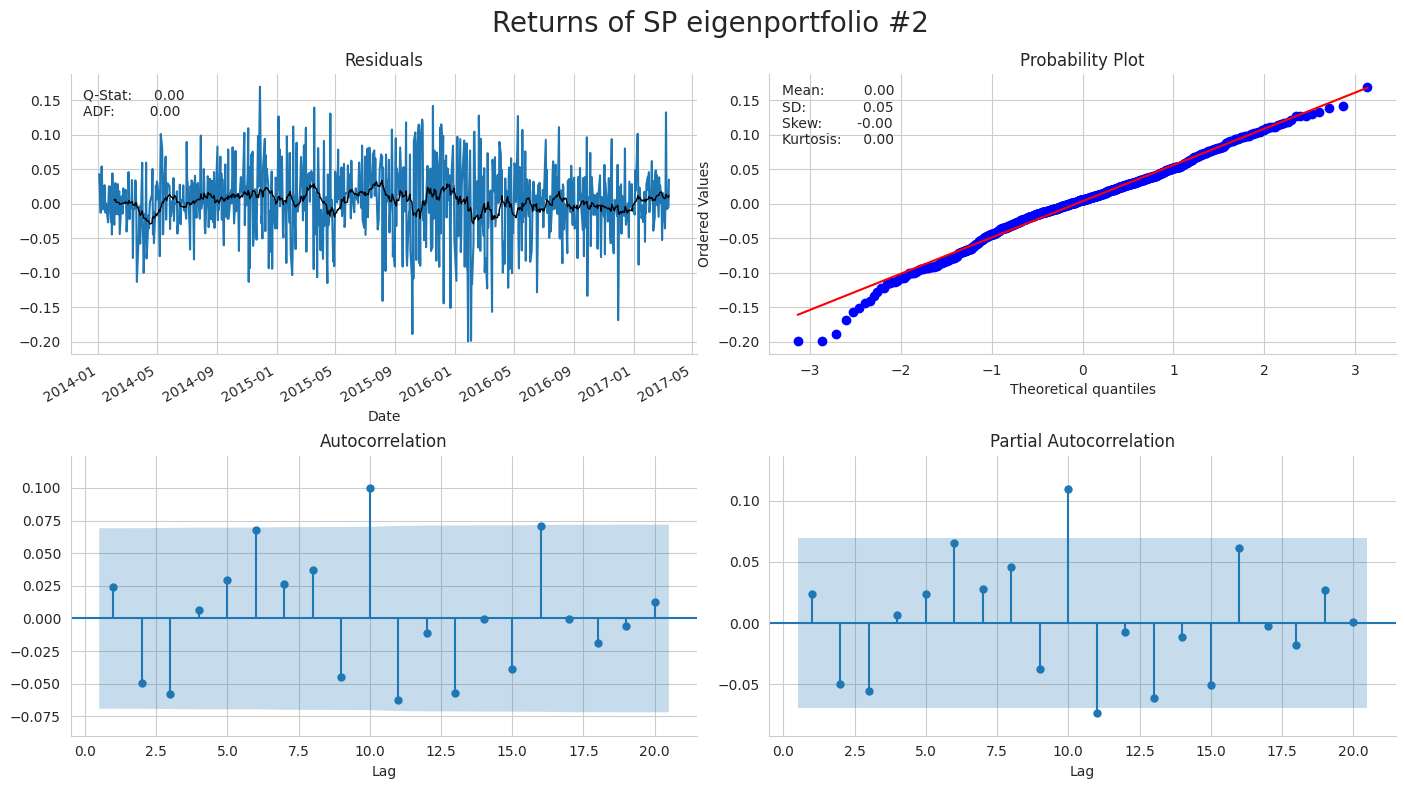

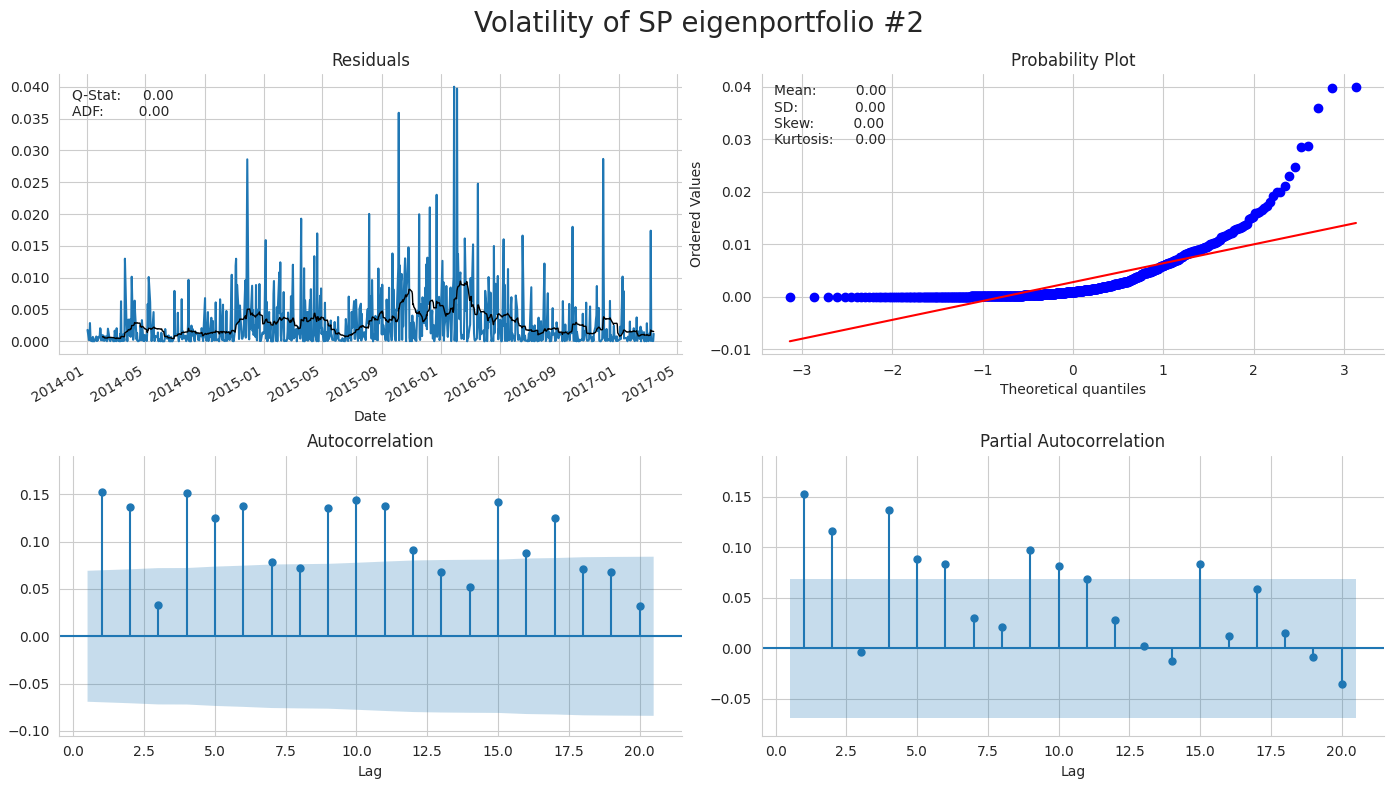

In [282]:
for i in range(3):
    plot_correlogram(SP_eport_train[i],lags=20,title=f'Returns of SP eigenportfolio #{i}')
    plot_correlogram((SP_eport_train[i]-DJI_eport_train[i].mean())**2,
                     lags=20,title=f'Volatility of SP eigenportfolio #{i}')

In [283]:
SP_eport_train[0]

Date
2014-01-03   -0.035799
2014-01-06    0.070397
2014-01-07   -0.142950
2014-01-08   -0.008815
2014-01-09   -0.046684
                ...   
2017-03-08    0.036124
2017-03-09    0.017183
2017-03-10   -0.085649
2017-03-13   -0.046156
2017-03-14    0.073703
Name: 0, Length: 804, dtype: float64

In [284]:
from tqdm import tqdm

In [286]:
DJI_portfolio

Date
2014-01-03    0.000616
2014-01-06   -0.016054
2014-01-07    0.034073
2014-01-08   -0.017968
2014-01-09   -0.003917
                ...   
2017-03-08   -0.009469
2017-03-09    0.002770
2017-03-10    0.016646
2017-03-13   -0.006664
2017-03-14   -0.005971
Name: 0, Length: 804, dtype: float64

In [287]:
y_pred

[]

In [300]:
train_size = 100
DJI_ARIMA_results = {}
time_range = DJI_eport_train.shape[0]


for j in range(3):
    DJI_portfolio = DJI_eport_train[j]
    y_true = DJI_portfolio.iloc[train_size:]

    for p in range(5):
        for q in range(5):
            aic, bic = [], []
            print(f'DJI portfolio {j}, ARIMA order = ({p},{q})')
            
            convergence_error = stationarity_error = 0
            y_pred = []

            for T in tqdm(range(train_size, time_range)):
                train_set = DJI_portfolio.iloc[T-train_size:T]
                try:
                    model = tsa.ARIMA(endog=train_set, order=(p,0,q)).fit()
                except LinAlgError:
                    convergence_error += 1
                except ValueError:
                    stationarity_error += 1

                forecast = model.forecast(steps=1).values[0]
                y_pred.append(forecast)
                aic.append(model.aic)
                bic.append(model.bic)

            result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                      .replace(np.inf, np.nan)
                      .dropna())

            rmse = np.sqrt(mean_squared_error(
                y_true=result.y_true, y_pred=result.y_pred))
            
            DJI_ARIMA_results[(j,p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

DJI portfolio 0, ARIMA order = (0,0)


100%|█████████████████████████████████████████| 704/704 [00:23<00:00, 29.50it/s]


DJI portfolio 0, ARIMA order = (0,1)


100%|█████████████████████████████████████████| 704/704 [00:30<00:00, 23.26it/s]


DJI portfolio 0, ARIMA order = (0,2)


100%|█████████████████████████████████████████| 704/704 [00:52<00:00, 13.43it/s]


DJI portfolio 0, ARIMA order = (0,3)


100%|█████████████████████████████████████████| 704/704 [01:17<00:00,  9.09it/s]


DJI portfolio 0, ARIMA order = (0,4)


100%|█████████████████████████████████████████| 704/704 [01:40<00:00,  6.97it/s]


DJI portfolio 0, ARIMA order = (1,0)


100%|█████████████████████████████████████████| 704/704 [00:23<00:00, 29.39it/s]


DJI portfolio 0, ARIMA order = (1,1)


100%|█████████████████████████████████████████| 704/704 [00:56<00:00, 12.38it/s]


DJI portfolio 0, ARIMA order = (1,2)


100%|█████████████████████████████████████████| 704/704 [01:31<00:00,  7.70it/s]


DJI portfolio 0, ARIMA order = (1,3)


100%|█████████████████████████████████████████| 704/704 [02:15<00:00,  5.19it/s]


DJI portfolio 0, ARIMA order = (1,4)


100%|█████████████████████████████████████████| 704/704 [02:30<00:00,  4.67it/s]


DJI portfolio 0, ARIMA order = (2,0)


 86%|███████████████████████████████████      | 603/704 [01:06<00:11,  9.04it/s]


KeyboardInterrupt: 

In [294]:
df_DJI_arima_results = pd.DataFrame(DJI_ARIMA_results).T
df_DJI_arima_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
df_DJI_arima_results.index.names = ['i','p', 'q']
df_DJI_arima_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26 entries, (0, 0, 0) to (1, 0, 0)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          26 non-null     float64
 1   AIC           26 non-null     float64
 2   BIC           26 non-null     float64
 3   convergence   26 non-null     float64
 4   stationarity  26 non-null     float64
dtypes: float64(5)
memory usage: 1.8 KB


In [ ]:
import os  
df_DJI_arima_results.to_csv('./DJI_arima_results.csv')